In [4]:
import torchaudio as ta
import matplotlib.pyplot as plt
import torch
# import pytorch_lightning as pl

import os

# import librosa

import IPython.display as ipd

import numpy as np

# import tensorflow as tf

import pandas as pd

import glob

from tqdm.auto import tqdm

from random import shuffle

# from numba import jit

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

ta.set_audio_backend("sox_io")

In [6]:
noise_dir = "./dataset/dataset/UrbanSound8K/audio/"
noise_metadata = "./dataset/dataset/UrbanSound8K/metadata/UrbanSound8K.csv"

signal_dir = "./dataset/dataset/cv-corpus-5.1-2020-06-22/en/clips/"
signal_metadata = "./dataset/dataset/cv-corpus-5.1-2020-06-22/en/train.tsv"

noise_df = pd.read_csv(noise_metadata)
signal_df = pd.read_csv(signal_metadata, sep="\t")

signal_df.head()

noise_paths = []
for root, dirs, files in os.walk(noise_dir):
    for name in files:
        if name.endswith(".wav"):
            noise_paths.append(os.path.join(root, name))
        

# @jit(nopython=True)
def get_sinal_paths(signal_dir):
    
    signal_paths = []
    for file in tqdm(os.listdir(signal_dir)):
        if file.endswith(".mp3"):
            signal_paths.append(os.path.join(signal_dir, file))
    return signal_paths

if os.path.exists("./dataset_loader_files/signal_paths_save.npy"):
    signal_paths = np.load("./dataset_loader_files/signal_paths_save.npy")
else:
    signal_paths = get_sinal_paths(signal_dir)
    
    

noise_paths = np.asarray(noise_paths)
# shuffle(noise_paths)
# np.save("./dataset_loader_files/noise_paths_save.npy", noise_paths)

FileNotFoundError: [Errno 2] No such file or directory: './dataset/dataset/UrbanSound8K/metadata/UrbanSound8K.csv'

In [4]:
# signal_paths = np.asarray(signal_paths)
# noise_paths = np.asarray(noise_paths)
    
# np.save("signal_paths_save.npy", signal_paths)
# np.save("noise_paths_save.npy", noise_paths)    

In [5]:
len(signal_paths), signal_paths[0]

(1427394,
 './dataset/cv-corpus-5.1-2020-06-22/en/clips/common_voice_en_20367387.mp3')

In [6]:
len(noise_paths)

8732

In [7]:
# error_paths = []
# new_paths = []
# default_sr = 16000

# noise_paths_tqdm = tqdm(noise_paths)
# for path in noise_paths_tqdm:
#     try:
#         noise, nsr = ta.load(path)
#         noise = ta.transforms.Resample(orig_freq=nsr, new_freq=default_sr)(noise)
# #         noise, nsr = librosa.load(path, sr=default_sr)
#         new_paths.append(path)
#     except:
#         error_paths.append(path)

# len(new_paths)

# new_paths = np.asarray(new_paths)
# new_paths = list(new_paths)
# type(new_paths)

In [8]:
# new_paths

# new_paths = torch.tensor(new_paths)
# torch.save(new_paths, "./noise_paths_save.pt")
# # np.save("./noise_paths_save.npy", new_paths)

In [9]:
def get_noise_from_sound(signal, noise, SNR):
    RMS_s = torch.sqrt(torch.mean(signal**2))
    
    RMS_n = torch.sqrt(RMS_s**2/pow(10., SNR/10))
    
    RMS_n_current = torch.sqrt(torch.mean(noise**2))
    noise = noise*(RMS_n/RMS_n_current)

    return noise

def get_mixed_signal(signal: torch.Tensor, noise: torch.Tensor, default_sr, sec, SNR):
        
    snip_audio = np.random.randint(0, 2)
    if snip_audio:
        signal = ta.transforms.Vad(sample_rate=default_sr)(signal)

    sig_length = int(default_sr * sec)

    if len(signal) > sig_length:
        signal = signal[: sig_length]
    elif len(signal) <= sig_length:
        zero_signal = torch.zeros((signal.size()))
        while len(signal) < sig_length:
            signal = torch.cat((signal, zero_signal))
            zero_signal = torch.zeros(signal.size())
        signal = signal[ : sig_length]


    noise_len = len(noise)
    signal_len = len(signal)

    if len(noise) > len(signal):
        noise = noise[0 : len(signal)]
    elif len(noise) <= len(signal):

        #noise = torch.cat((noise, torch.zeros((len(signal) - len(noise)))))
        for i in range(int(len(signal)/len(noise))+1):
            noise = torch.cat((noise, noise))

        noise = noise[:len(signal)]

    noise = get_noise_from_sound(signal, noise, SNR)

    signal_noise = signal+noise
    return signal_noise, signal, noise

In [10]:
def normalize(tensor):
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

In [25]:
%%time
SNR = np.random.randint(0, 50)
rand = np.random.randint(0, 50)
default_sr = 16000
normalized = False
# SNR = 10

snip_audio = np.random.randint(0, 2)

noise, nsr = librosa.load(noise_paths[rand], sr=default_sr)
signal, ssr = librosa.load(signal_paths[rand], sr=default_sr)

noise = torch.from_numpy(noise)
signal = torch.from_numpy(signal)


# noise, nsr = ta.load(str(noise_paths[rand]), normalize=True)
noise = ta.transforms.Resample(orig_freq=nsr, new_freq=default_sr)(noise)
# signal, ssr = ta.load(str(signal_paths[rand]), normalize=True)
signal = ta.transforms.Resample(orig_freq=ssr, new_freq=default_sr)(signal)

if snip_audio:
    signal = ta.transforms.Vad(sample_rate=default_sr)(signal)
    
noise = noise.to(device)
signal = signal.to(device)


#noise = torch.squeeze(noise, dim=0)
signal = torch.squeeze(signal, dim=0)
print(SNR)

noise.shape, snip_audio

/home/vamsik1211/Data/ML/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


37
CPU times: user 545 ms, sys: 35.7 ms, total: 581 ms
Wall time: 569 ms


(torch.Size([64000]), 1)

In [29]:
16*14*8/60

29.866666666666667

In [12]:
signal.min()

tensor(-0.7528)

In [13]:
noise = noise.to(device)
signal = signal.to(device)

In [14]:
def_sr = default_sr
n_fft=400
win_length=400
hop_len=200
f_min = 0
f_max = def_sr // 2
normalized = True
sec = 4

In [15]:
signal_noise, signal, noise = get_mixed_signal(signal, noise, default_sr, sec, SNR)
signal_noise, signal, noise = normalize(signal_noise), normalize(signal), normalize(noise)

In [16]:
signal_stft = torch.stft(signal, n_fft, hop_length=hop_len, win_length=win_length, normalized=normalized)

In [17]:
signal_stft.shape

torch.Size([201, 321, 2])

In [18]:
signal_restore = torch.istft(signal_stft, n_fft, hop_length=hop_len, win_length=win_length, normalized=normalized)
audio = signal_restore

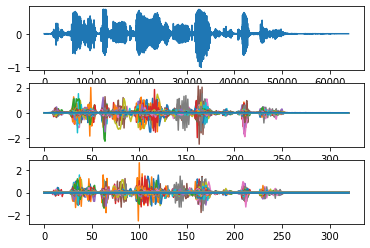

In [19]:
fig, axes = plt.subplots(3, 1)
axes[0].plot(audio.t().to(device).numpy())
axes[1].plot(signal_stft[:,:,0].t().to(device).numpy())
axes[2].plot(signal_stft[:,:,1].t().to(device).numpy())
plt.show()

# x = audio.numpy()
x = audio.t().to(device).numpy()
ipd.Audio(x, rate=default_sr)

In [20]:
audio = signal
x = audio.t().to(device).numpy()
ipd.Audio(x, rate=default_sr)

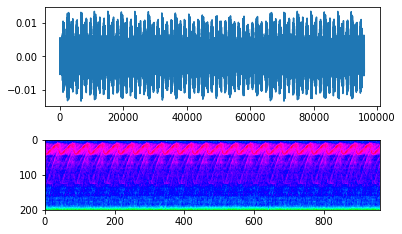

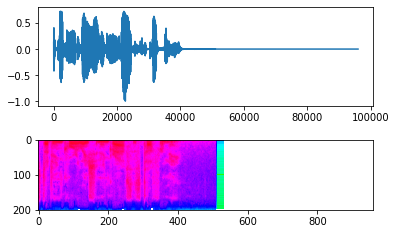

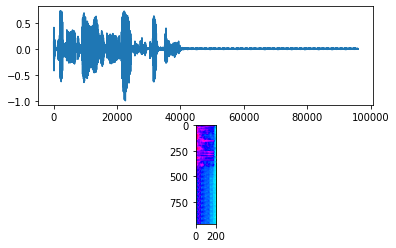

In [24]:
noise = noise.to(device)
signal = signal.to(device)

# pre_emphasis = 0.95
# noise = np.interp(noise, (noise.min(), noise.max()), (-1, 1))
# signal = np.interp(signal, (signal.min(), noise.max()), (-1, 1))

# noise = np.append(noise[0], noise[1:] - pre_emphasis * noise[:-1])
# signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

# noise = torch.from_numpy(noise).double()
# signal = torch.from_numpy(signal).double()


# SNR = 0

def_sr = default_sr
n_fft = 400
win_length = n_fft//2
hop_len = n_fft // 4
f_min = 0
f_max = def_sr // 2
sec = 6
signal_noise, signal, noise = get_mixed_signal(signal, noise, default_sr, sec, SNR)

signal_noise.type()



spec_transform = ta.transforms.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_len).to(device)


fig, axes = plt.subplots(2, 1)

specgram =spec_transform(noise)
axes[0].plot(noise.to(torch.device("cpu")).numpy())
specgram = specgram.to(torch.device("cpu"))
axes[1].imshow(specgram.log2().numpy(), cmap=plt.cm.hsv)

noise.mean()
specgram.log2()[:, :].numpy().shape
sr = ssr
x = noise.to(torch.device("cpu")).numpy()
ipd.Audio(x, rate=default_sr)

specgram.shape

# mel_scale = ta.transforms.MelScale()(noise[0])
# specgram = ta.transforms.Spectrogram()(mel_scale)
# plt.imshow(specgram.log2().numpy(), cmap=plt.cm.hsv)

specgram.shape


fig, axes = plt.subplots(2, 1)
# signal = ta.transforms.AmplitudeToDB()(signal)

specgram_noiseless = spec_transform(signal)
axes[0].plot(signal.t().to(torch.device("cpu")).numpy())
specgram = specgram_noiseless.to(torch.device("cpu"))
axes[1].imshow(specgram.log2().numpy(), cmap=plt.cm.hsv)

sr = ssr
x = signal.to(torch.device("cpu")).numpy()
ipd.Audio(x, rate=default_sr)

specgram.shape


fig, axes = plt.subplots(2, 1)


specgram = spec_transform(signal_noise)
axes[0].plot(signal_noise.t().to(torch.device("cpu")).numpy())
specgram = specgram.to(torch.device("cpu"))
axes[1].imshow(specgram.log2().t().numpy(), cmap=plt.cm.hsv)
sr = ssr
x = signal_noise.to(torch.device("cpu")).numpy()
ipd.Audio(x, rate=default_sr)

In [23]:
signal.t().shape, signal.shape

(torch.Size([96000]), torch.Size([96000]))

In [25]:
specgram.shape

torch.Size([201, 961])

In [56]:
new_spec = specgram.unsqueeze(0)

In [57]:
new_spec.shape

torch.Size([1, 201, 961])

In [58]:
new_spec[:, :, :].shape

torch.Size([1, 201, 961])

64


/home/vamsik1211/Data/ML/lib/python3.7/site-packages/torchaudio/functional.py:110: UserWarning: istft has been moved to PyTorch and will be removed from torchaudio, please use torch.istft instead.
  'istft has been moved to PyTorch and will be removed from torchaudio, '


128
192
256
320
384


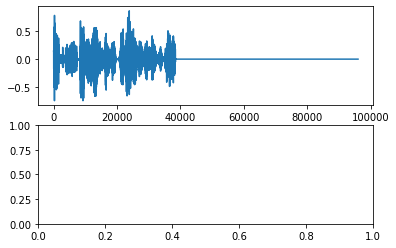

CPU times: user 40.1 s, sys: 76 ms, total: 40.2 s
Wall time: 5.14 s


In [59]:
%%time

fig, axes = plt.subplots(2, 1)

device = torch.device("cpu")
specgram = specgram_noiseless.to(device)
audio_lst = [0, 0, 0, 0, 0, 0]
for i in range(1, len(audio_lst)+1):
    n_iter = 64*i
    print(n_iter)
    audio_lst[i-1] = ta.transforms.GriffinLim(n_fft=n_fft, n_iter=n_iter, win_length=win_length, hop_length=hop_len, rand_init=False, normalized=False, momentum=0.9).to(device)(specgram)
    
audio = torch.stack(audio_lst, dim=0).sum(dim=0)/len(audio_lst)
# audio = ta.transforms.MuLawDecoding()(audio)
device = torch.device("cpu")
axes[0].plot(audio.t().to(device).numpy())
plt.show()

# x = audio.numpy()
x = audio.t().to(device).numpy()
ipd.Audio(x, rate=default_sr)

In [26]:
audio.shape, signal.shape

(torch.Size([128000]), torch.Size([128000]))

In [64]:
noise_dir = "./dataset/UrbanSound8K/audio/"
noise_metadata = "./dataset/UrbanSound8K/metadata/UrbanSound8K.csv"

signal_dir = "./dataset/cv-corpus-5.1-2020-06-22/en/clips/"
signal_metadata = "./dataset/cv-corpus-5.1-2020-06-22/en/train.tsv"

In [65]:
noise_df = pd.read_csv(noise_metadata)
signal_df = pd.read_csv(signal_metadata, sep="\t")

In [18]:
signal_path = os.path.join(signal_dir, signal_df["path"][1])

In [19]:
signal_path

'./dataset/cv-corpus-5.1-2020-06-22/en/clips/common_voice_en_20009653.mp3'

In [15]:
noise_df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [27]:
cleared_audio = ta.transforms.Vad(sample_rate=default_sr)(signal)

In [28]:
x = cleared_audio.numpy()
ipd.Audio(x, rate=default_sr)